In [60]:
# Import libraries and dependencies

import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
import hvplot.pandas
import statsmodels.api as sm
from matplotlib import pyplot as plt
import holoviews as hv
from holoviews import opts


## 1. Reading in the Data

First, we will read in the Ethereum data, using the date as the index. Our data comes from Gemini, a cryptocurrency exchange and trading venue. 

Our dataset contains the following information:
* Date/Time
* Ticker (ETH/USD, in this case)
* Open/High/Low/Close Price, for each hour from 2016-05-09 13:00:00 to 2022-10-13 00:00:00
* Volume traded, denominated in both ETH and USD

In [44]:
# Read in the data 
# The first row in the data gives the soruce, so we need to skip over it
eth = pd.read_csv(Path('../Resources/Gemini_ETHUSD_1h.csv'),
                 skiprows=1,
                  index_col='date',
                  parse_dates=True,
                  infer_datetime_format=True)

# Display data
display(eth.head())
display(eth.tail())

,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2022-10-13 00:00:00,1665619200000,ETH/USD,1294.40,1296.60,1292.46,1295.26,162.209379,210103.320244
2022-10-12 23:00:00,1665615600000,ETH/USD,1294.70,1296.29,1292.87,1294.40,119.920839,155225.534002
2022-10-12 22:00:00,1665612000000,ETH/USD,1299.77,1301.22,1294.44,1294.70,158.825518,205631.398155
2022-10-12 21:00:00,1665608400000,ETH/USD,1298.96,1303.00,1298.77,1299.77,168.917546,219553.958764
2022-10-12 20:00:00,1665604800000,ETH/USD,1297.90,1299.41,1297.01,1298.96,21.727735,28223.458656


,unix,symbol,open,high,low,close,Volume ETH,Volume USD
date,,,,,,,,
2016-05-09 17:00:00,1462813200,ETH/USD,9.83,9.83,9.48,9.49,329.553213,3127.459991
2016-05-09 16:00:00,1462809600,ETH/USD,9.99,9.99,9.79,9.83,62.379450,613.189994
2016-05-09 15:00:00,1462806000,ETH/USD,10.00,10.00,9.99,9.99,10.973567,109.625935
2016-05-09 14:00:00,1462802400,ETH/USD,9.55,10.00,9.55,10.00,235.774075,2357.740748
2016-05-09 13:00:00,1462798800,ETH/USD,0.00,12.00,0.00,9.55,432.562115,4130.968200


## 2. Data Cleaning

Next, we will complete a number of steps to pre-process the data. This includes:

1. Removing all columns except date/time, closing price, and volume (USD).
2. Calculating hourly returns by calling the 'pct_change()' function
3. Removing hours where no trading occurred (see more details below)

In [4]:
# Remove all data except closing price and volume
eth_prices = eth[['close', 'Volume USD']]

# Reverse the order
eth_prices = eth_prices.sort_index(ascending=True)

display(eth_prices.head())

,close,Volume USD
date,,
2016-05-09 13:00:00,9.55,4130.968200
2016-05-09 14:00:00,10.00,2357.740748
2016-05-09 15:00:00,9.99,109.625935
2016-05-09 16:00:00,9.83,613.189994
2016-05-09 17:00:00,9.49,3127.459991


In [5]:
# Calculate hourly percent change (this will be the response variable) 
eth_prices['hourly_returns'] = eth_prices['close'].pct_change().shift(-1)

display(eth_prices.head())

,close,Volume USD,hourly_returns
date,,,
2016-05-09 13:00:00,9.55,4130.968200,0.047120
2016-05-09 14:00:00,10.00,2357.740748,-0.001000
2016-05-09 15:00:00,9.99,109.625935,-0.016016
2016-05-09 16:00:00,9.83,613.189994,-0.034588
2016-05-09 17:00:00,9.49,3127.459991,-0.013699


For our first regression, we need each row of the returns dataframe to have the following values (predictors):

1. The lagged hourly returns from hours t-1 through t-60
2. The current month
3. The current day
4. The current year

In [6]:
# Remove NA rows
eth_prices = eth_prices.dropna()

# Set date/month/year
eth_prices['year'] = eth_prices.index.year
eth_prices['month'] = eth_prices.index.month
eth_prices['day'] = eth_prices.index.day
display(eth_prices.head())

,close,Volume USD,hourly_returns,year,month,day
date,,,,,,
2016-05-09 13:00:00,9.55,4130.968200,0.047120,2016,5,9
2016-05-09 14:00:00,10.00,2357.740748,-0.001000,2016,5,9
2016-05-09 15:00:00,9.99,109.625935,-0.016016,2016,5,9
2016-05-09 16:00:00,9.83,613.189994,-0.034588,2016,5,9
2016-05-09 17:00:00,9.49,3127.459991,-0.013699,2016,5,9


Notice that some of the hours had no trading volume. Looking at how this data varies by year, it becomes clear that almost all of the "zero-volume days" happened before 2018. It seems likely that in the early days of Ethereum, when trading volume was limited, there were more discrepencies in the hourly data. Another explanation is that the Gemini exchange may have halted trading during these periods. In light of this, we will remove these items from the dataset and any rows that reference these rows.

In [8]:
sum(eth_prices['Volume USD'] == 0)
zero_vol = eth_prices[eth_prices['Volume USD'] == 0]

display(zero_vol.groupby('year').count())

,close,Volume USD,hourly_returns,month,day
year,,,,,
2016,1934,1934,1934,1934,1934
2017,389,389,389,389,389
2018,58,58,58,58,58
2019,51,51,51,51,51
2020,33,33,33,33,33
2021,15,15,15,15,15
2022,5,5,5,5,5


In [9]:
# Add NaN values to rows with no volume
eth_prices['hourly_returns'] = np.where(eth_prices['Volume USD'] == 0, np.nan, eth_prices['hourly_returns'])

In [10]:
# Calculate lagged hourly returns
for i in range(1, 61):
    eth_prices[f'lag{i}'] = eth_prices['hourly_returns'].shift(i)


In [11]:
# Remove values that reference hours with zero volume
eth_prices = eth_prices.dropna()

## 3. Modeling

This is where things start to get interesting. Here, we will train a multiple regression model predicting $R_{t, t+1}$, the hourly return from hour $t$ to $t+1$ with each of $\{R_{t-i, t-i+1} | i \in [1, 60]\}$ and an intercept. Then, we will graph the confidence intervals for each of the $R_{t-i, t-i+1}$ to see which lagged hourly returns have the most significant effect on the next hour of returns.

In [14]:
# Set X and Y 
X = eth_prices.filter(regex='lag|year|month|day')
X = sm.add_constant(X)
Y = eth_prices['hourly_returns']

# Fit the model and output summary
eth_model = sm.OLS(Y, X).fit()
print(eth_model.summary())

                            OLS Regression Results                            
Dep. Variable:         hourly_returns   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.512
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           4.42e-52
Time:                        19:29:25   Log-Likelihood:             1.2862e+05
No. Observations:               42572   AIC:                        -2.571e+05
Df Residuals:                   42508   BIC:                        -2.566e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1073      0.071      1.512      0.1

Given that the day, month, and year effects are not significant predictors. We will remove them from the regression and re-run it, this time only with the lagged returns as predictors.

In [15]:
# Set X and Y 
X = eth_prices.filter(regex='lag')
X = sm.add_constant(X)
Y = eth_prices['hourly_returns']

# Fit the model and output summary
eth_model = sm.OLS(Y, X).fit()
print(eth_model.summary())

                            OLS Regression Results                            
Dep. Variable:         hourly_returns   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.785
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           9.48e-53
Time:                        19:30:30   Log-Likelihood:             1.2862e+05
No. Observations:               42572   AIC:                        -2.571e+05
Df Residuals:                   42511   BIC:                        -2.566e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   5.76e-05      3.073      0.0

Next, we will calculate the confidence intervals for each of the coefficients and plot these in order to compare them.

In [17]:
param_err = eth_model.params - eth_model.conf_int()[0]

coef_df = pd.DataFrame({'coef': eth_model.params.values[1:],
                        'err': param_err.values[1:],
                        'varname': param_err.index.values[1:]
                       })

display(coef_df.head())

,coef,err,varname
0,-0.029228,0.009494,lag1
1,-0.033608,0.009516,lag2
2,-0.020215,0.009542,lag3
3,-0.007192,0.009540,lag4
4,-0.009180,0.009541,lag5


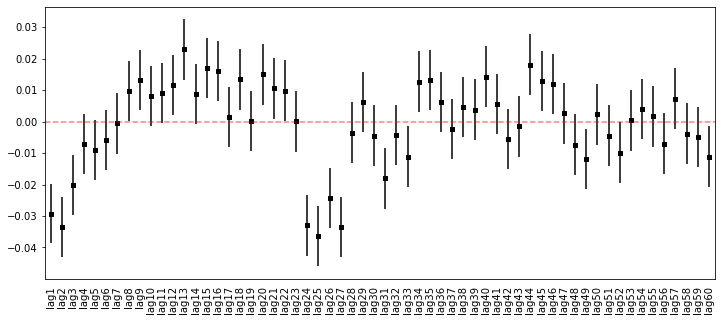

In [19]:
# Create plot figure
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the conf. ints
coef_df.plot(x='varname', y='coef', kind='bar', ax=ax, 
             yerr='err', legend=False, color='none',
             xlabel='')

# Add the means
ax.scatter(x=np.arange(coef_df.shape[0]),
           marker='s', s=20,
           y=coef_df['coef'], color='black')

# Add zero line
ax.axhline(y=0, color='red', linestyle='--', alpha=.5)
ax.xaxis.set_ticks_position('none')

A few things stand out to us about the above graph and the results of our regression:

* As expected, our results matched the results of the paper we attempted to replicate.
* The effect of the closest lagged returns (hours 1-3) was significant (~2-4 bps). These effects are likely due to features of the market microstructure on Gemini. 
* There are significant positive effects for hours 8, 9, 12, 13, 15, 16, 18, and 21. 
* There are highly significant negative effects for hours 24-27 of about equal size (~2.5-4bps). Interestingly, there is a stark start/end to this trend after hour 23/before hour 28. 
* The same pattern appears to hold, but to a lesser extent, for the next 24 hours of lagged returns.

In [174]:
subset = eth_prices['2018-12-23':'2018-12-27']

subset.iloc[22]

close                130.280000
Volume USD        762343.612732
hourly_returns        -0.005680
year                2018.000000
month                 12.000000
                      ...      
lag56                 -0.024850
lag57                 -0.008472
lag58                 -0.001209
lag59                  0.003031
lag60                  0.007768
Name: 2018-12-23 22:00:00, Length: 66, dtype: float64

In [1]:
p = subset.hvplot.line(
    x='date',
    y='hourly_returns',
frame_width=500,
frame_height=500,
color='gray',
xlabel='Date',
ylabel='Hourly Returns',
title='Hourly Returns of ETH, Dec. 23, 2018 - Dec. 25, 2018')

p2 = subset.hvplot.line(
    x='date',
    y='close',
frame_width=500,
frame_height=500,
color='red',
xlabel='Date',
ylabel='Price',
title='Price of ETH, Dec. 23, 2018 - Dec. 25, 2018')

v1 = hv.VLine(subset.index[22])
v2 = hv.VLine(subset.index[23]) 
v3 = hv.VLine(subset.index[24])
v4 = hv.VLine(subset.index[46])
v5 = hv.VLine(subset.index[47])
v6 = hv.VLine(subset.index[48])

overlay = p * v2 * v5 + p2 * v2 * v3 * v5 * v6
overlay.opts(
    opts.VLine(color='blue', line_width=1, alpha=1, line_dash='dashed'))

NameError: name 'subset' is not defined

The above graph demonstrates an extreme historical representation of the effect we've documented in the regression above. At 11pm on Dec. 23, 2018, the price of Ethereum rose 11.3% in the span of an hour. 24 hours later, at midnight on Christmas Eve, the price of ETH dropped nearly 7% in just over an hour, due, in our opinion, at least in part because of the effect of the 24-hour window.

The first graph shows the hourly returns of ETH, with dotted lines marking 11:00pm on Dec. 23/24, the hours after which these price changes occurred. 

The second graph shows the closing hourly prices of ETH with dotted lines marking 11pm-12am on Dec 23/24 and 11pm-12am on Dec 24/25, the hours during which the largest changes in price occurred. 

From a traders point of view, the following events would have transpired:
1. The price of ETH rose from \$129.54 to \$144.23 from 11pm on Dec. 23 to 12am on Dec. 24, an 11.3% increase.
2. Over the next 24 hours, traders observed a 24-hour return window of 10%+ for ETH.
3. Starting at 11pm on Dec. 24, the 24-hour returns of ETH fell rapidly as the initial price bump moved out of the window. 
4. Assuming the prices moved linearly intra-hour, by 11:30pm, the price of ETH sat around \$134.13 with a 24-hour lagged price of \$136.89
5. At this point (11:30pm), the 24-hour return would show -2.02%, vs. 7.32% at 11:00pm
6. Traders continued selling until 12am on Dec. 25, at which point the 24-hour return window would have shown -10.39%. 



The size of this effect in this instance is truly remarkable and demonstrates just how powerful the effect of the 24-hour window can be, especially when large changes in price happen in a relatively short amount of time. Additionally, low liquidity during the holidays likely magnified the impact of trades placed during this period. 